In [2]:
import json

In [3]:
!pip install pandas 

You should consider upgrading via the '/Users/onszammel/.pyenv/versions/3.9.13/envs/pyspark-env/bin/python -m pip install --upgrade pip' command.


In [4]:
import json
import pandas as pd

# Step 1: Load JSON file
with open("data/train.json", "r", encoding="utf-8") as f:
    data = json.load(f)
refuted_claims = [doc for doc in data if doc.get("label") == "Refuted"]


cleaned_data = []

for claim in refuted_claims:
    cleaned_data.append({
        "claim": claim.get("claim"),
        "label": claim.get("label"),
        "justification": claim.get("justification"),
        "claim_date": claim.get("claim_date"),
        "speaker": claim.get("speaker"),
        "fact_checking_article": claim.get("fact_checking_article"),
        "reporting_source": claim.get("reporting_source"),
        "location_ISO_code": claim.get("location_ISO_code"),
        "claim_types": claim.get("claim_types"),
        "fact_checking_strategies": claim.get("fact_checking_strategies"),
    })


dfVerif = pd.DataFrame(cleaned_data)



In [5]:

dfVerif["claim_date"] = pd.to_datetime(dfVerif["claim_date"], errors="coerce", dayfirst=True)



In [35]:
dfVerif.head(1
             )

,claim,label,justification,claim_date,speaker,fact_checking_article,reporting_source,location_ISO_code,claim_types,fact_checking_strategies
0,donald trump delivered the largest tax cuts in...,Refuted,Three tax bills have been larger than that of ...,2020-08-25,Eric Trump,https://web.archive.org/web/20210111003633/htt...,Speech at The Republican National Convention,US,[Numerical Claim],"[Written Evidence, Numerical Comparison]"


In [8]:
dfM = pd.read_csv("data/claims_analysis_verif.csv")

In [23]:
len(dfM)

559

In [31]:
dfM_unique = dfM.drop_duplicates()
len(dfM_unique)

551

In [ ]:
# Convert the 'claim' column in both dataframes to lowercase
dfVerif = dfVerif.drop_duplicates(subset=['claim'])
dfM_unique['claim'] = dfM_unique['claim'].str.lower()
dfVerif['claim'] = dfVerif['claim'].str.lower()



/var/folders/69/hc7pt9fs55zf_r21r0t85jrm0000gn/T/ipykernel_92559/3979406340.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfM_unique['claim'] = dfM_unique['claim'].str.lower()
/var/folders/69/hc7pt9fs55zf_r21r0t85jrm0000gn/T/ipykernel_92559/3979406340.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfVerif['claim'] = dfVerif['claim'].str.lower()


551

In [36]:
# Merge the dataframes on the 'claim' column
merged_df = pd.merge(dfM_unique, dfVerif, on='claim', how='left')

# Display the merged dataframe
len(merged_df)

merged_df.to_csv("data/claims_analysis_verif_enriched.csv", index=False)

In [40]:
merged_df.head(1)

,claim,response,explanation,label,justification,claim_date,speaker,fact_checking_article,reporting_source,location_ISO_code,claim_types,fact_checking_strategies
0,donald trump delivered the largest tax cuts in...,Correct,"The Tax Cuts and Jobs Act of 2017, enacted dur...",Refuted,Three tax bills have been larger than that of ...,2020-08-25,Eric Trump,https://web.archive.org/web/20210111003633/htt...,Speech at The Republican National Convention,US,[Numerical Claim],"[Written Evidence, Numerical Comparison]"


implementation of BLEU Score : Motivation

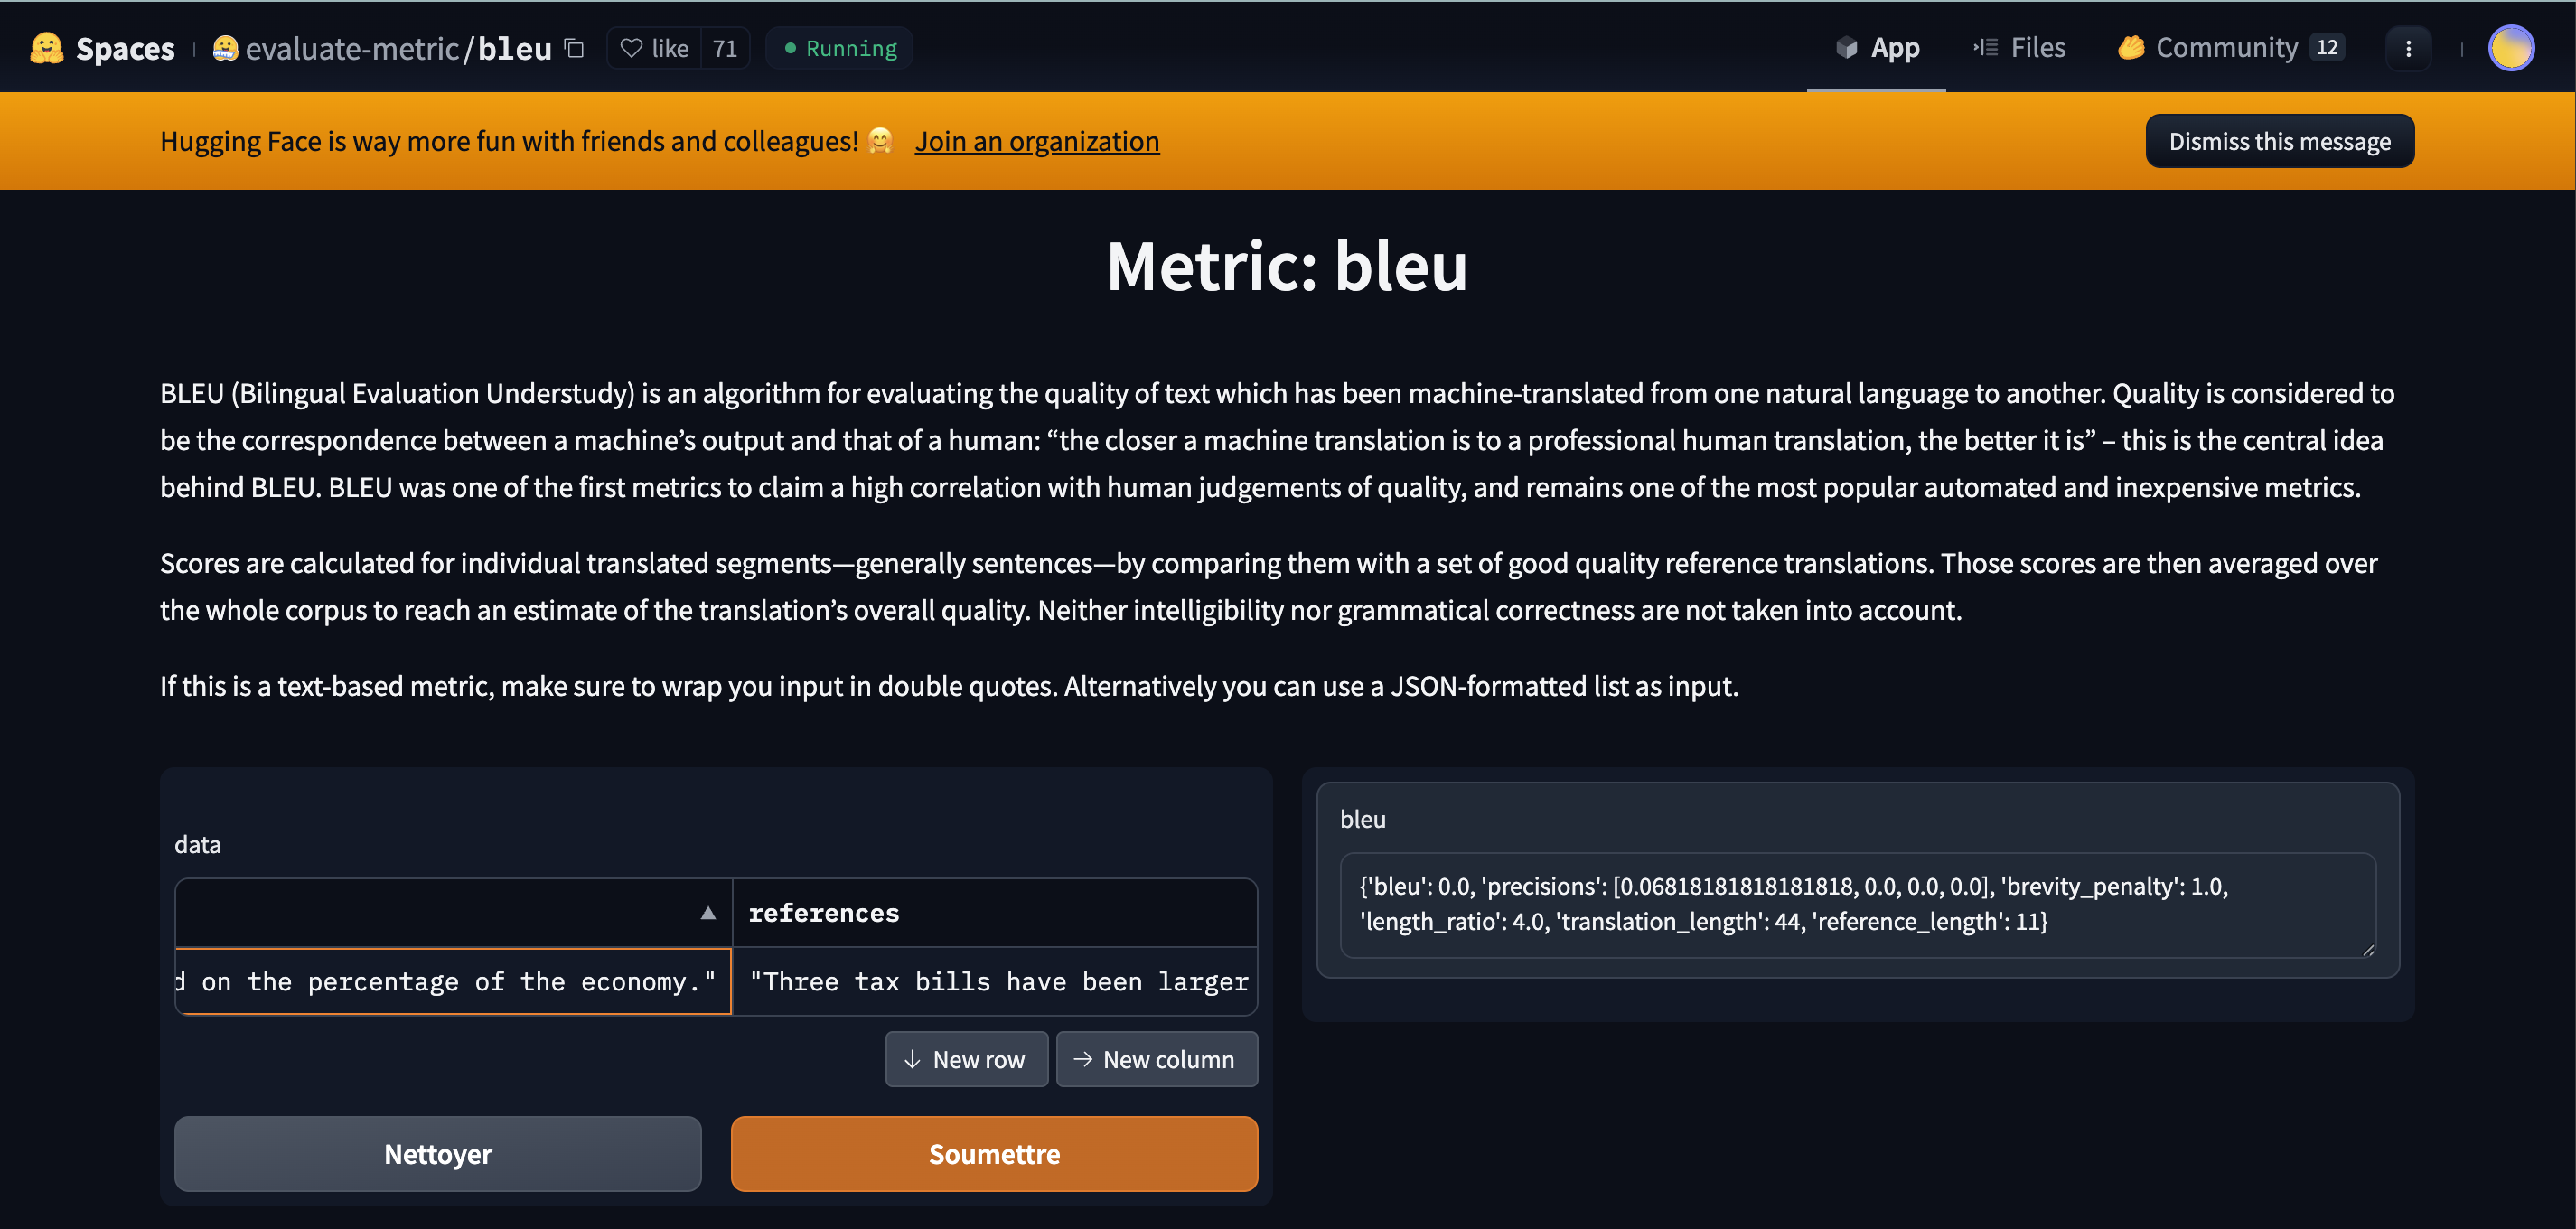

In [37]:
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 2.8 MB/s eta 0:00:0000:0100:01
  Using cached click-8.1.8-py3-none-any.whl (98 kB)
You should consider upgrading via the '/Users/onszammel/.pyenv/versions/3.9.13/envs/pyspark-env/bin/python -m pip install --upgrade pip' command.


In [65]:
import pandas as pd
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Ensure punkt is available
nltk.download('punkt', quiet=True)

def calculate_bleu(candidate, reference, weights=(0.25, 0.25, 0.25, 0.25), smoothing=True):
    """Calculate BLEU score between candidate and reference strings."""
    if not candidate.strip() or not reference.strip():
        return 0.0
    candidate_tokens = candidate.lower().split()
    reference_tokens = [reference.lower().split()]
    smoothing_fn = SmoothingFunction().method1 if smoothing else None
    return sentence_bleu(reference_tokens, candidate_tokens, weights=weights, smoothing_function=smoothing_fn)

def calculate_bleu_for_dataframes(df1, df2, explanation_col='explanation', reference_col='justification',
                                  weights=(0.25, 0.25, 0.25, 0.25), smoothing=True):
    """Compute BLEU scores for two aligned DataFrames."""
    if len(df1) != len(df2):
        raise ValueError("DataFrames must have the same length")
    
    result_df = pd.DataFrame({
        explanation_col: df1[explanation_col],
        reference_col: df2[reference_col],
    })
    
    result_df['bleu_score'] = [
        calculate_bleu(str(c or ""), str(r or ""), weights, smoothing)
        for c, r in zip(df1[explanation_col], df2[reference_col])
    ]
    return result_df

def calculate_bleu_variants(candidate, reference):
    """Return multiple BLEU variants for a candidate-reference pair."""
    if not candidate.strip() or not reference.strip():
        return {k: 0.0 for k in ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4', 'BLEU-4-smooth']}
    
    candidate_tokens = candidate.lower().split()
    reference_tokens = [reference.lower().split()]
    smooth = SmoothingFunction().method1
    
    return {
        'BLEU-1': sentence_bleu(reference_tokens, candidate_tokens, weights=(1, 0, 0, 0)),
        'BLEU-2': sentence_bleu(reference_tokens, candidate_tokens, weights=(0.5, 0.5, 0, 0)),
        'BLEU-3': sentence_bleu(reference_tokens, candidate_tokens, weights=(1/3, 1/3, 1/3, 0)),
        'BLEU-4': sentence_bleu(reference_tokens, candidate_tokens),
        'BLEU-4-smooth': sentence_bleu(reference_tokens, candidate_tokens, smoothing_function=smooth),
    }

# Example usage
if __name__ == "__main__":
    # Dummy example (replace merged_df with your DataFrame)
    df1 = merged_df[['explanation']].copy()
    df2 = merged_df[['justification']].copy()

    result = calculate_bleu_for_dataframes(df1, df2)
    print(result.round(4))

    # Variants for first row
    print("\nBLEU Variants:")
    print(calculate_bleu_variants(df1['explanation'][0], df2['justification'][0]))

    # Summary stats
    print("\nSummary Stats:")
    print(result['bleu_score'].describe())


                                           explanation  \
0    The Tax Cuts and Jobs Act of 2017, enacted dur...   
1    The CLAT 2020 was indeed postponed and not con...   
2    According to the Nigerian Revenue Mobilization...   
3    The Edo Modular Refinery is a project initiate...   
4    South Africa has consistently reported the hig...   
..                                                 ...   
546  Historical records and photographs confirm Red...   
547  News reports confirm the University of Zimbabw...   
548  Multiple news reports corroborate that 122 Mus...   
549  The claim is accurate. While Blackout Tuesday ...   
550  Photographic evidence from the 2019 G7 Leaders...   

                                         justification  bleu_score  
0    Three tax bills have been larger than that of ...      0.0066  
1    The answer and credible source show that the c...      0.0124  
2    The answer shows that 26.72% goes to states so...      0.0134  
3    The refinery, Edo Refi

/Users/onszammel/.pyenv/versions/pyspark-env/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/onszammel/.pyenv/versions/pyspark-env/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/onszammel/.pyenv/versions/pyspark-env/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lowe

In [66]:
result_df

,explanation,justification,bleu_score
0,"The Tax Cuts and Jobs Act of 2017, enacted dur...",Three tax bills have been larger than that of ...,0.006596
1,The CLAT 2020 was indeed postponed and not con...,The answer and credible source show that the c...,0.012385
2,According to the Nigerian Revenue Mobilization...,The answer shows that 26.72% goes to states so...,0.013401
3,The Edo Modular Refinery is a project initiate...,"The refinery, Edo Refinery and Petrochemical L...",0.019252
4,South Africa has consistently reported the hig...,It seems that SA consumes less alcohol. Theref...,0.010182
...,...,...,...
546,Historical records and photographs confirm Red...,"According to the source link, the photograph r...",0.008161
547,News reports confirm the University of Zimbabw...,The second Q&A pair show the official statemen...,0.013686
548,Multiple news reports corroborate that 122 Mus...,"It appears that the claim is untrue, whilst th...",0.015128
549,The claim is accurate. While Blackout Tuesday ...,It seems from the last QA that the posts are n...,0.029478


In [ ]:
import pandas as pd
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Ensure punkt is available
nltk.download('punkt', quiet=True)

def calculate_bleu_variants(candidate, reference):
    """Return multiple BLEU variants for a candidate-reference pair."""
    if not candidate.strip() or not reference.strip():
        return {k: 0.0 for k in ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4', 'BLEU-4-smooth']}
    
    candidate_tokens = candidate.lower().split()
    reference_tokens = [reference.lower().split()]
    smooth = SmoothingFunction().method1
    
    return {
        'BLEU-1': sentence_bleu(reference_tokens, candidate_tokens, weights=(1, 0, 0, 0)),
        'BLEU-2': sentence_bleu(reference_tokens, candidate_tokens, weights=(0.5, 0.5, 0, 0)),
        'BLEU-3': sentence_bleu(reference_tokens, candidate_tokens, weights=(1/3, 1/3, 1/3, 0)),
        'BLEU-4': sentence_bleu(reference_tokens, candidate_tokens),
        'BLEU-4-smooth': sentence_bleu(reference_tokens, candidate_tokens, smoothing_function=smooth),
    }

def calculate_bleu_for_dataframes(df1, df2, explanation_col='explanation', reference_col='justification'):
    """Compute BLEU scores (all variants) for two aligned DataFrames."""
    if len(df1) != len(df2):
        raise ValueError("DataFrames must have the same length")
    
    result_df = pd.DataFrame({
        explanation_col: df1[explanation_col],
        reference_col: df2[reference_col],
    })
    
    bleu_results = [calculate_bleu_variants(str(c or ""), str(r or "")) 
                    for c, r in zip(df1[explanation_col], df2[reference_col])]
    
    bleu_df = pd.DataFrame(bleu_results)
    return pd.concat([result_df, bleu_df], axis=1)


if __name__ == "__main__":
    df1 = merged_df[['explanation']].copy()
    df2 = merged_df[['justification']].copy()
    result_BLEU = calculate_bleu_for_dataframes(df1, df2)

    #print(result.round(4))
    #print("\nSummary Stats:")
    #print(result.drop(columns=['explanation','justification']).describe())


/Users/onszammel/.pyenv/versions/pyspark-env/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/onszammel/.pyenv/versions/pyspark-env/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/onszammel/.pyenv/versions/pyspark-env/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lowe

In [76]:
result_BLEU

,explanation,justification,BLEU-1,BLEU-2,BLEU-3,BLEU-4,BLEU-4-smooth
0,"The Tax Cuts and Jobs Act of 2017, enacted dur...",Three tax bills have been larger than that of ...,0.081081,4.247486e-155,3.424019e-206,9.721610e-232,0.006596
1,The CLAT 2020 was indeed postponed and not con...,The answer and credible source show that the c...,0.217391,6.954939e-155,4.756750e-206,1.243996e-231,0.012385
2,According to the Nigerian Revenue Mobilization...,The answer shows that 26.72% goes to states so...,0.157895,5.927288e-155,4.275814e-206,1.148419e-231,0.013401
3,The Edo Modular Refinery is a project initiate...,"The refinery, Edo Refinery and Petrochemical L...",0.375000,9.134565e-155,5.704795e-206,1.425661e-231,0.019252
4,South Africa has consistently reported the hig...,It seems that SA consumes less alcohol. Theref...,0.052632,3.422121e-155,2.964684e-206,8.726095e-232,0.010182
...,...,...,...,...,...,...,...
546,Historical records and photographs confirm Red...,"According to the source link, the photograph r...",0.120773,4.224983e-155,2.976981e-206,7.902267e-232,0.008161
547,News reports confirm the University of Zimbabw...,The second Q&A pair show the official statemen...,0.068966,4.962917e-02,3.798448e-104,3.323079e-155,0.013686
548,Multiple news reports corroborate that 122 Mus...,"It appears that the claim is untrue, whilst th...",0.235526,7.989836e-02,4.759247e-104,3.673148e-155,0.015128
549,The claim is accurate. While Blackout Tuesday ...,It seems from the last QA that the posts are n...,0.200000,1.167748e-01,6.819356e-02,1.629835e-78,0.029478


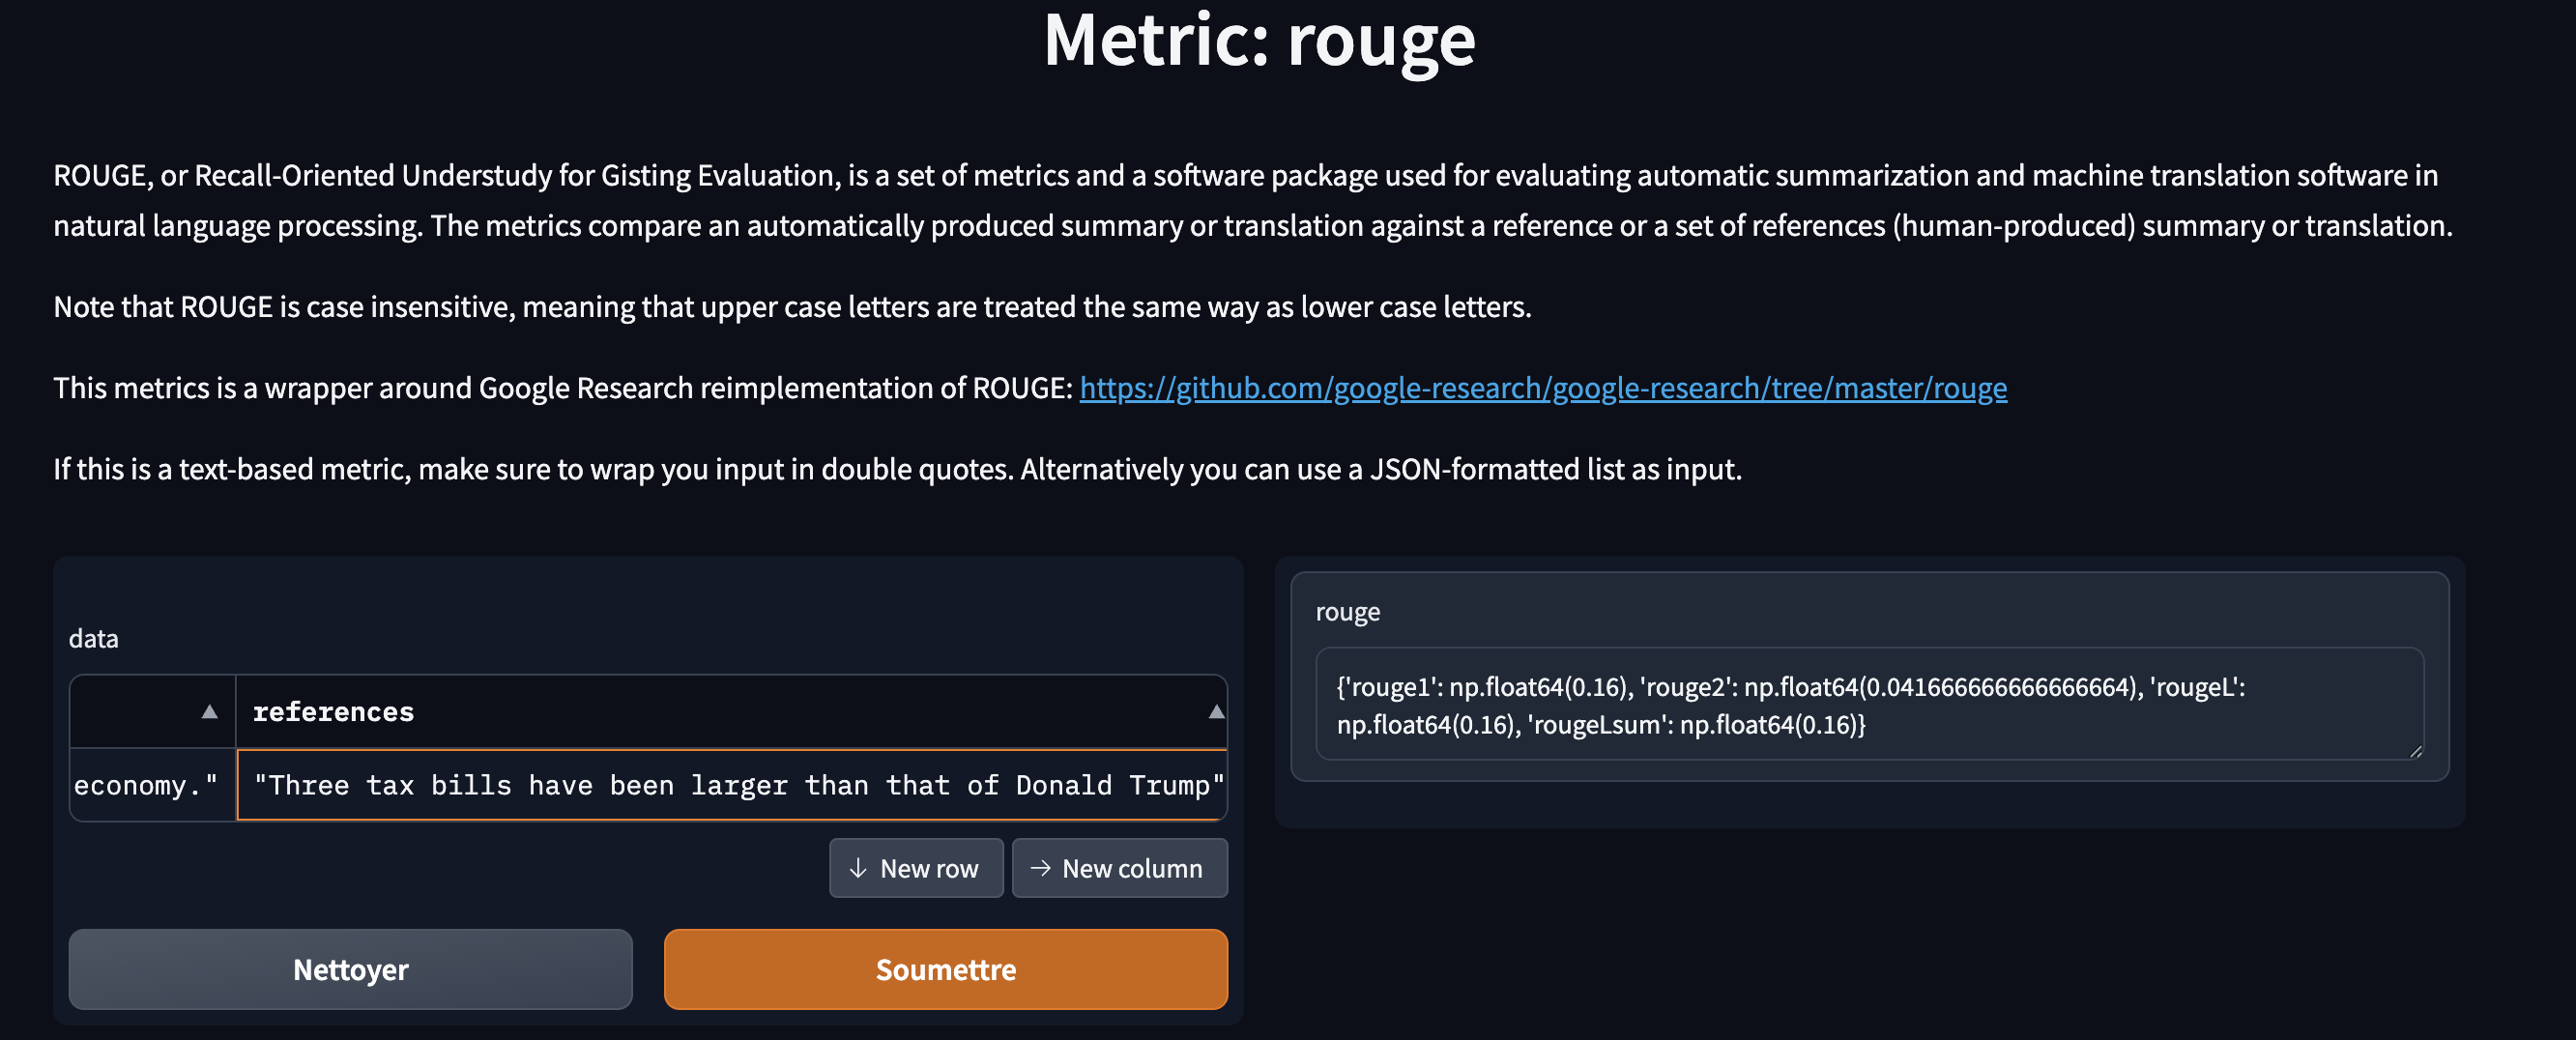

In [71]:
!pip install rouge-score


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 KB 4.2 MB/s eta 0:00:00
Using legacy 'setup.py install' for rouge-score, since package 'wheel' is not installed.
  Running setup.py install for rouge-score ... done
You should consider upgrading via the '/Users/onszammel/.pyenv/versions/3.9.13/envs/pyspark-env/bin/python -m pip install --upgrade pip' command.


In [ ]:
import pandas as pd
from rouge_score import rouge_scorer

def calculate_rouge_variants(candidate, reference):
    """
    Calculate ROUGE scores between a candidate and a reference text.
    
    Returns:
        dict with ROUGE-1, ROUGE-2, and ROUGE-L (precision, recall, f1).
    """
    if not candidate.strip() or not reference.strip():
        return {
            'ROUGE-1_P': 0.0, 'ROUGE-1_R': 0.0, 'ROUGE-1_F1': 0.0,
            'ROUGE-2_P': 0.0, 'ROUGE-2_R': 0.0, 'ROUGE-2_F1': 0.0,
            'ROUGE-L_P': 0.0, 'ROUGE-L_R': 0.0, 'ROUGE-L_F1': 0.0
        }
    
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, candidate)
    
    return {
        'ROUGE-1_P': scores['rouge1'].precision,
        'ROUGE-1_R': scores['rouge1'].recall,
        'ROUGE-1_F1': scores['rouge1'].fmeasure,
        'ROUGE-2_P': scores['rouge2'].precision,
        'ROUGE-2_R': scores['rouge2'].recall,
        'ROUGE-2_F1': scores['rouge2'].fmeasure,
        'ROUGE-L_P': scores['rougeL'].precision,
        'ROUGE-L_R': scores['rougeL'].recall,
        'ROUGE-L_F1': scores['rougeL'].fmeasure,
    }

def calculate_rouge_for_dataframes(df1, df2, explanation_col='explanation', reference_col='justification'):

    if len(df1) != len(df2):
        raise ValueError("DataFrames must have the same length")
    
    result_df = pd.DataFrame({
        explanation_col: df1[explanation_col],
        reference_col: df2[reference_col],
    })
    
    rouge_results = [calculate_rouge_variants(str(c or ""), str(r or "")) 
                     for c, r in zip(df1[explanation_col], df2[reference_col])]
    
    rouge_df = pd.DataFrame(rouge_results)
    return pd.concat([result_df, rouge_df], axis=1)

if __name__ == "__main__":
    df1 = merged_df[['explanation']].copy()
    df2 = merged_df[['justification']].copy()
    result_Rouge = calculate_rouge_for_dataframes(df1, df2)
    
    #print(result.round(4))
    #print("\nSummary Stats (ROUGE F1 only):")
    #print(result[['ROUGE-1_F1','ROUGE-2_F1','ROUGE-L_F1']].describe())


In [74]:
result_Rouge 

,explanation,justification,ROUGE-1_P,ROUGE-1_R,ROUGE-1_F1,ROUGE-2_P,ROUGE-2_R,ROUGE-2_F1,ROUGE-L_P,ROUGE-L_R,ROUGE-L_F1
0,"The Tax Cuts and Jobs Act of 2017, enacted dur...",Three tax bills have been larger than that of ...,0.102564,0.363636,0.160000,0.026316,0.100000,0.041667,0.102564,0.363636,0.160000
1,The CLAT 2020 was indeed postponed and not con...,The answer and credible source show that the c...,0.208333,0.277778,0.238095,0.000000,0.000000,0.000000,0.166667,0.222222,0.190476
2,According to the Nigerian Revenue Mobilization...,The answer shows that 26.72% goes to states so...,0.200000,0.285714,0.235294,0.000000,0.000000,0.000000,0.150000,0.214286,0.176471
3,The Edo Modular Refinery is a project initiate...,"The refinery, Edo Refinery and Petrochemical L...",0.375000,0.375000,0.375000,0.000000,0.000000,0.000000,0.375000,0.375000,0.375000
4,South Africa has consistently reported the hig...,It seems that SA consumes less alcohol. Theref...,0.105263,0.166667,0.129032,0.000000,0.000000,0.000000,0.105263,0.166667,0.129032
...,...,...,...,...,...,...,...,...,...,...,...
546,Historical records and photographs confirm Red...,"According to the source link, the photograph r...",0.272727,0.187500,0.222222,0.047619,0.032258,0.038462,0.181818,0.125000,0.148148
547,News reports confirm the University of Zimbabw...,The second Q&A pair show the official statemen...,0.103448,0.125000,0.113208,0.035714,0.043478,0.039216,0.068966,0.083333,0.075472
548,Multiple news reports corroborate that 122 Mus...,"It appears that the claim is untrue, whilst th...",0.344828,0.270270,0.303030,0.071429,0.055556,0.062500,0.206897,0.162162,0.181818
549,The claim is accurate. While Blackout Tuesday ...,It seems from the last QA that the posts are n...,0.200000,0.360000,0.257143,0.068182,0.125000,0.088235,0.133333,0.240000,0.171429


LLM as a judge 

In [79]:
!pip install ollama

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 KB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.8/444.8 KB 2.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.2/107.2 KB 1.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 KB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 6.6 MB/s eta 0:00:00a 0:00:01
You should consider upgrading via the '/Users/onszammel/.pyenv/versions/3.9.13/envs/pyspark-env/bin/python -m pip install --upgrade pip' command.


In [80]:
import pandas as pd
import ollama
import json

def judge_with_llama3(claim, explanation, justification, model="llama3.1:latest"):
    """
    Use LLaMA 3 (via Ollama) to judge correlation between explanation and justification.
    Returns: dict with correlation_score, confidence_score, explanation
    """
    prompt = f"""
You are an expert evaluator. 
Given a claim, an explanation (model output), and a justification (ground truth), 
rate how well the explanation aligns with the justification.

Respond in valid JSON only with this format:
{{
  "correlation_score": float (0.0 to 1.0),
  "confidence_score": float (0.0 to 1.0),
  "explanation": "short text explaining both scores"
}}

Claim: {claim}
Explanation: {explanation}
Justification: {justification}
    """
    
    response = ollama.chat(model=model, messages=[{"role": "user", "content": prompt}])
    text_response = response["message"]["content"].strip()
    
    try:
        result = json.loads(text_response)
    except json.JSONDecodeError:
        # fallback if model outputs invalid JSON
        result = {
            "correlation_score": 0.0,
            "confidence_score": 0.0,
            "explanation": f"Invalid response: {text_response}"
        }
    return result


In [81]:

def judge_dataframe(df, claim_col="claim", explanation_col="explanation", justification_col="justification"):
    """
    Apply LLaMA judgment to each row of the DataFrame.
    Adds correlation_score, confidence_score, llm_explanation columns.
    """
    results = []
    for _, row in df.iterrows():
        result = judge_with_llama3(
            row[claim_col],
            row[explanation_col],
            row[justification_col]
        )
        results.append(result)
    
    results_df = pd.DataFrame(results)
    return pd.concat([df.reset_index(drop=True), results_df], axis=1)



bash : ollama pull llama3.1:latest

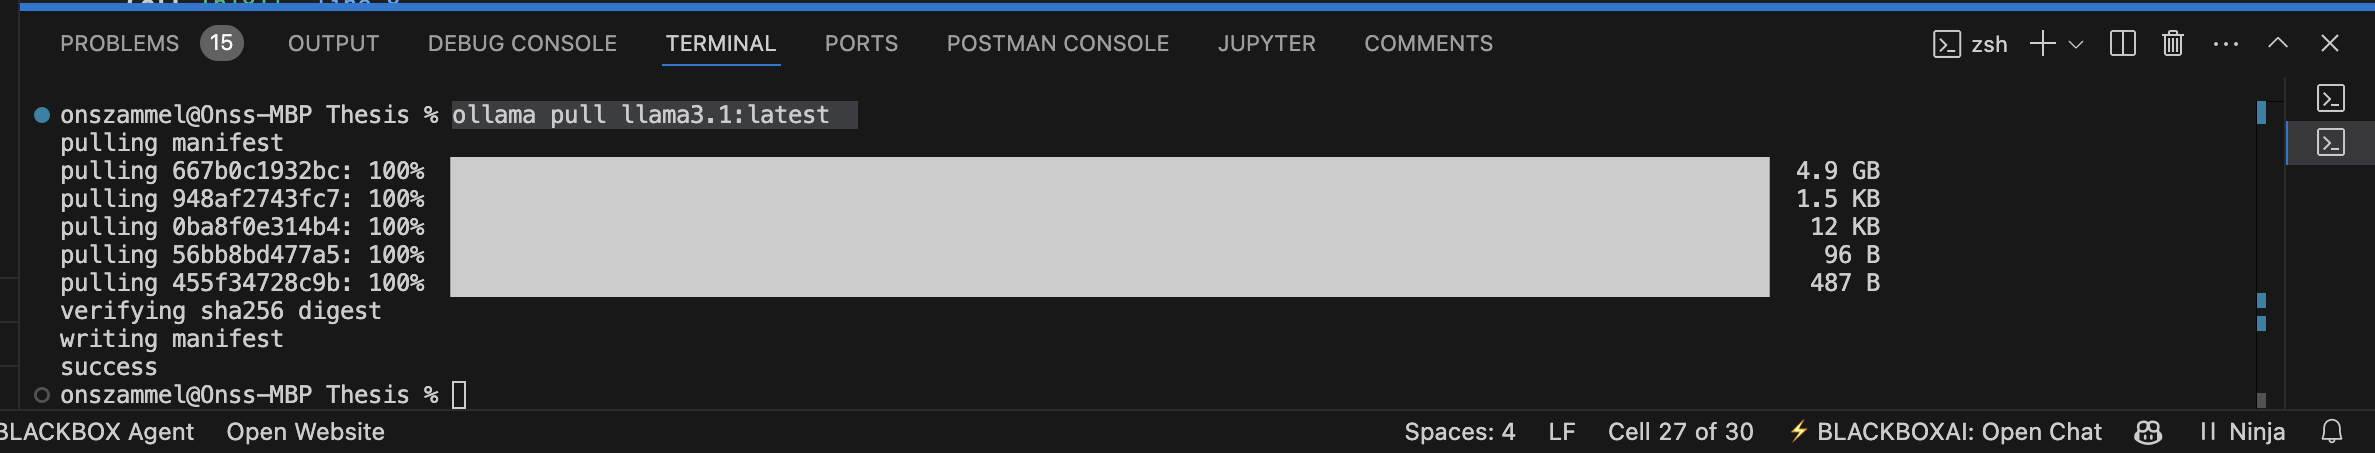

In [83]:

# Example usage
if __name__ == "__main__":
    # Sample data
    df = pd.DataFrame({
        "claim": ["The Earth revolves around the Sun", "Water boils at 90°C at sea level"],
        "explanation": ["The Earth completes an orbit in 365 days", "Water boils at 100°C at sea level"],
        "justification": ["Correct, the Earth revolves around the Sun once per year", "Incorrect, water boils at 100°C at sea level"]
    })

    result_df = judge_dataframe(df)
    print(result_df)


                               claim  \
0  The Earth revolves around the Sun   
1   Water boils at 90°C at sea level   

                                explanation  \
0  The Earth completes an orbit in 365 days   
1         Water boils at 100°C at sea level   

                                       justification  correlation_score  \
0  Correct, the Earth revolves around the Sun onc...               0.75   
1       Incorrect, water boils at 100°C at sea level               0.00   

   confidence_score                                        explanation  
0               0.9  The explanation is partially relevant to the c...  
1               1.0  The explanation is completely opposite to the ...  


In [84]:
result_df

,claim,explanation,justification,correlation_score,confidence_score,explanation
0,The Earth revolves around the Sun,The Earth completes an orbit in 365 days,"Correct, the Earth revolves around the Sun onc...",0.75,0.9,The explanation is partially relevant to the c...
1,Water boils at 90°C at sea level,Water boils at 100°C at sea level,"Incorrect, water boils at 100°C at sea level",0.00,1.0,The explanation is completely opposite to the ...


In [85]:
df = merged_df[['claim', 'explanation', 'justification']].copy()
result_df_judge = judge_dataframe(df)
print(result_df_judge)

KeyboardInterrupt: 